In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#wyświetl wszystkie wiersze i kolumny
pd.options.display.max_rows = None
pd.options.display.max_columns = None

## potrzebne instalacje

In [0]:
!pip install --upgrade tables
!pip install lightgbm
!pip install scikit-plot
!pip install catboost

## zamontowanie dysku Google

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
cd "drive/My Drive/Colab Notebooks/konkurs"

## pobranie danych

In [0]:
train = pd.read_hdf('train_warsaw.h5')
train.info()

In [0]:
test = pd.read_hdf('test_warsaw.h5')
test.info()

## oglądamy dane

In [0]:
train.head()

In [0]:
test.head()

In [0]:
train.describe()

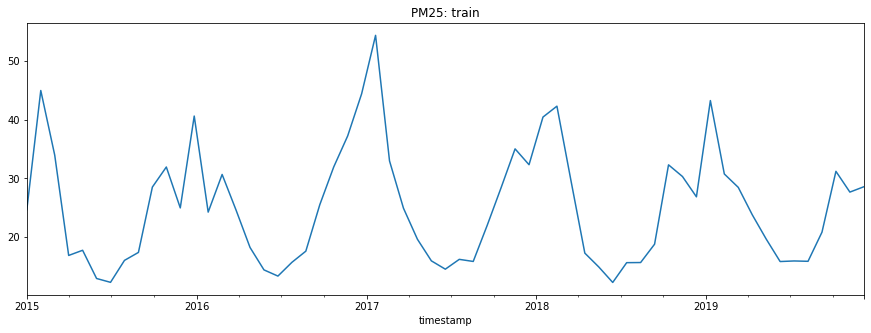

In [0]:
train.resample('30d').mean()['pm25'].plot(title='PM25: train', figsize=(15, 5));

## preparowanie danych

### najpierw dane związane z datą

In [0]:
train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month
train['day'] = train['timestamp'].dt.day
train['hour'] = train['timestamp'].dt.hour
train['weekday']= train['timestamp'].dt.weekday

In [0]:
test['year'] = test['timestamp'].dt.year
test['month'] = test['timestamp'].dt.month
test['day'] = test['timestamp'].dt.day
test['hour'] = test['timestamp'].dt.hour
test['weekday']= test['timestamp'].dt.weekday

### przygotowanie danych kategorialnych

In [0]:
train['icon'].fillna('Unknown',inplace=True)
train['ozone'].fillna('Unknown',inplace=True)
train['summary'].fillna('Unknown',inplace=True)
train['precipType'].fillna('Unknown',inplace=True)

In [0]:
train['icon_cat'] = pd.factorize(train['icon'])[0]
train['ozone_cat'] = pd.factorize(train['ozone'])[0]
train['summary_cat'] = pd.factorize(train['summary'])[0]
train['precipType_cat'] = pd.factorize(train['precipType'])[0]

### liczymy logarytm pm25 (prostujemy rozkład)

In [0]:
train['pm25_log'] = train['pm25'].map(lambda x: np.log(x))

In [0]:
train.describe()

In [0]:
train.columns

### przygotowanie dodatkowych kolumn (przygotowujemy mean, min, max, median dla cechy tego samego dnia i godziny ale rok temu oraz w okresie poprzedzających lat, tego samego dnia i godziny ale szukamy najbliższego tego samego dnia tygodnia (chcemy porównać jak było rok temu ale też w piątek) rok temu oraz w okresie poprzedzających lat, o tej samej godzinie ale w ciągu poprzedzających 3 dni, 2 dni oraz poprzedniego dnia)

tutaj też funkcje od inicjalizacji kolumn i ich kasowania (gdyby była potrzeba powtarzania tej operacji

Uwaga ! To trwa...nie było kompletnie czasu na rozważania jak to zrobić szybko

Uwaga ! Dodaję pokazywanie na bieżąco postępu - Google Colab ma jednak limity na output i może nie pokazywać do końca (ale policzy do końca)

Uwaga ! Tutaj i dalej podczas przygotowania danych są uproszczone założenia odnośnie super jakości tych danych, nie rozważamy czy dla każdego rekordu mamy kompletne dane z przeszłości (train zawiera luki w czasie, jak dane są to dobrze, zakładamy, że potrzebujemy uzyskać jak najwięcej średnich wartości z przeszłości z różnych okresów)

Uwaga ! Tutaj i dalej warto sobie zapisywać przygotowane już dane po każdym etapie eksperymentów

In [0]:
import datetime
def GetStatsFor(year, month, day, hour, feature, mode):
    timestamp = datetime.datetime(year, month, day, hour)
    weekday = timestamp.weekday()
    if mode=='last_year':
        df = train[(train.year==year-1)&(train.month==month)&(train.day==day)&(train.hour==hour)][feature]
        #tylko dla ujednolicenia w ten sposób
        return np.mean(df),np.max(df),np.min(df),np.median(df)
    if mode=='last_years':
        df = train[(train.year<year)&(train.month==month)&(train.day==day)&(train.hour==hour)][feature]
        return np.mean(df),np.max(df),np.min(df),np.median(df)
    if mode=='last_year_weekday':
        df = train[(train.timestamp>=(timestamp + pd.DateOffset(years=-1) + pd.DateOffset(days=-4)))&(train.timestamp<=(timestamp + pd.DateOffset(years=-1) + pd.DateOffset(days=+4)))&(train.weekday==weekday)&(train.hour==hour)][feature]
        #tylko dla ujednolicenia w ten sposób
        return np.mean(df),np.max(df),np.min(df),np.median(df)
    if mode=='last_years_weekday':
        df = train[
                   (
                   (
                       (train.timestamp>=(timestamp + pd.DateOffset(years=-1) + pd.DateOffset(days=-4)))
                   &
                       (train.timestamp<=(timestamp + pd.DateOffset(years=-1) + pd.DateOffset(days=4)))
                   )
                   |
                   (
                       (train.timestamp>=(timestamp + pd.DateOffset(years=-2) + pd.DateOffset(days=-4)))
                   &
                       (train.timestamp<=(timestamp + pd.DateOffset(years=-2) + pd.DateOffset(days=4)))
                   )
                   |
                   (
                       (train.timestamp>=(timestamp + pd.DateOffset(years=-3) + pd.DateOffset(days=-4)))
                   &
                       (train.timestamp<=(timestamp + pd.DateOffset(years=-3) + pd.DateOffset(days=4)))
                   )
                   |
                   (
                       (train.timestamp>=(timestamp + pd.DateOffset(years=-4) + pd.DateOffset(days=-4)))
                   &
                       (train.timestamp<=(timestamp + pd.DateOffset(years=-4) + pd.DateOffset(days=4)))
                   )
                   |
                   (
                       (train.timestamp>=(timestamp + pd.DateOffset(years=-5) + pd.DateOffset(days=-4)))
                   &
                       (train.timestamp<=(timestamp + pd.DateOffset(years=-5) + pd.DateOffset(days=4)))
                   )
                   )
                   &
                   (train.weekday==weekday)&(train.hour==hour)][feature]
        return np.mean(df),np.max(df),np.min(df),np.median(df)
    if mode=='last_3days':
        df = train[(train.timestamp>=(timestamp + pd.DateOffset(days=-3)))&(train.timestamp<timestamp)&(train.hour==hour)][feature]
        return np.mean(df),np.max(df),np.min(df),np.median(df)
    if mode=='last_2days':
        df = train[(train.timestamp>=(timestamp + pd.DateOffset(days=-2)))&(train.timestamp<timestamp)&(train.hour==hour)][feature]
        return np.mean(df),np.max(df),np.min(df),np.median(df)
    if mode=='last_day':
        df = train[(train.timestamp>=(timestamp + pd.DateOffset(days=-1)))&(train.timestamp<timestamp)&(train.hour==hour)][feature]
        #tylko dla ujednolicenia w ten sposób
        return np.mean(df),np.max(df),np.min(df),np.median(df)
    return 0

In [0]:
def InitCols(computed_feats,modes,df):
    for feat in computed_feats:
        for mode in modes:
            if ((mode!='last_day')&(mode!='last_year')&(mode!='last_year_weekday')):
                stats = ['mean','max','min','median']
            else:    
                stats = ['mean']
            for stat in stats:
              col_name = feat+'_'+mode+'_'+stat
              df[col_name] = 0

In [0]:
def DelCols(df):
    colNames = df.columns[df.columns.str.contains('last')] 
    for col_name in colNames:
       del df[col_name]

In [0]:
from tqdm import tqdm
import time
def ComputeColumns(df, modes, computed_feats):
  start_time = time.time()
  with tqdm(total=df.shape[0]*len(computed_feats)*len(modes)) as pbar:
    for index, row in df.iterrows():
        for feat in computed_feats:
            for mode in modes:
                (mean_val,max_val,min_val,median_val) = GetStatsFor(row['year'],row['month'],row['day'],row['hour'],feat,mode)
                col_name = feat+'_'+mode
                df.loc[index,col_name+'_mean'] = mean_val
                if ((mode!='last_day')&(mode!='last_year')&(mode!='last_year_weekday')):
                    df.loc[index,col_name+'_max'] = max_val
                    df.loc[index,col_name+'_min'] = min_val
                    df.loc[index,col_name+'_median'] = median_val
                pbar.update(1)    
  end_time = time.time()
  print("Elapsed time was %g seconds" % (end_time - start_time))                

### wyliczamy dodatkowe kolumny, liczymy zarówno dla train jak i test (tutaj dane też uzyskujemy z train, wszystko dotyczy historii co najmniej z wczoraj), liczymy dla wielu cech


In [0]:
DelCols(train)
DelCols(test)

In [0]:
computed_feats=['temperature', 'pm25', 'apparentTemperature', 'cloudCover',
       'dewPoint', 'humidity', 'precipAccumulation',
       'precipIntensity', 'precipProbability', 'pressure',
       'temperature', 'uvIndex', 'visibility', 'windBearing',
       'windGust', 'windSpeed', 'winter_break', 
       'icon_cat', 'ozone_cat', 'summary_cat', 'precipType_cat', 'pm25_log']
modes = ['last_year','last_years','last_year_weekday','last_years_weekday','last_3days','last_2days','last_day']
InitCols(computed_feats, modes,train)
InitCols(computed_feats, modes,test)

In [0]:
modes = ['last_year','last_years','last_year_weekday','last_years_weekday','last_3days','last_2days','last_day']

In [0]:
ComputeColumns(train,modes,computed_feats)

In [0]:
ComputeColumns(test,modes,computed_feats)

### dodajemy i liczymy lag na pm25 (dane sprzed godziny), dla test finalnie istotny będzie lag tylko w pierwszym wierszu każdej wyliczanej "przerwy" (uzyskany z train)

In [0]:
#lag na pm25
train['pm25_lag'] = train['pm25'].shift(1)
train['pm25_log_lag'] = train['pm25_log'].shift(1)

In [0]:
#lag na pm25 ale w test
test['pm25_lag']=0
test['pm25_log_lag']=0

In [0]:
def ComputeLagForTest():
  start_time = time.time()
  with tqdm(total=test.shape[0]) as pbar:
    for index, row in test.iterrows():
        timestamp = row['timestamp']
        df = train[(train.timestamp>=(timestamp + pd.DateOffset(hours=-1)))&(train.timestamp<timestamp)]['pm25']
        lag = np.mean(df)
        test.loc[index,'pm25_lag'] = lag
        df = train[(train.timestamp>=(timestamp + pd.DateOffset(hours=-1)))&(train.timestamp<timestamp)]['pm25_log']
        lag = np.mean(df)
        test.loc[index,'pm25_log_lag'] = lag
        pbar.update(1)    
  end_time = time.time()
  print("Elapsed time was %g seconds" % (end_time - start_time))   

In [0]:
ComputeLagForTest()

### tutaj staramy się uzupełnić dane tam gdzie ich nie uzyskaliśmy, robimy to w ten sposób, że jak czegoś brakuje z odległej przeszłości, bierzemy średnią z bliższej (tutaj jest wersja uproszczona - bierzemy średnią z poprzedniego dnia)

In [0]:
from tqdm import tqdm
import time
def ComputeNanColumns(df, computed_feats):
  start_time = time.time()
  with tqdm(total=df.shape[0]*len(computed_feats)) as pbar:
    for index, row in df.iterrows():
        for feat in computed_feats:
           if (np.isnan(row[feat+'_last_year_mean'])):
             df.loc[index,feat+'_last_year_mean'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_years_mean'])):
             df.loc[index,feat+'_last_years_mean'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_years_min'])):
             df.loc[index,feat+'_last_years_min'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_years_max'])):
             df.loc[index,feat+'_last_years_max'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_years_median'])):
             df.loc[index,feat+'_last_years_median'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_year_weekday_mean'])):
             df.loc[index,feat+'_last_year_weekday_mean'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_years_weekday_mean'])):
             df.loc[index,feat+'_last_years_weekday_mean'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_years_weekday_min'])):
             df.loc[index,feat+'_last_years_weekday_min'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_years_weekday_max'])):
             df.loc[index,feat+'_last_years_weekday_max'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_years_weekday_median'])):
             df.loc[index,feat+'_last_years_weekday_median'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_2days_mean'])):
             df.loc[index,feat+'_last_2days_mean'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_2days_min'])):
             df.loc[index,feat+'_last_2days_min'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_2days_max'])):
             df.loc[index,feat+'_last_2days_max'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_2days_median'])):
             df.loc[index,feat+'_last_2days_median'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_3days_mean'])):
             df.loc[index,feat+'_last_3days_mean'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_3days_min'])):
             df.loc[index,feat+'_last_3days_min'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_3days_max'])):
             df.loc[index,feat+'_last_3days_max'] = row[feat+'_last_day_mean']
           if (np.isnan(row[feat+'_last_3days_median'])):
             df.loc[index,feat+'_last_3days_median'] = row[feat+'_last_day_mean']
           pbar.update(1)    
  end_time = time.time()
  print("Elapsed time was %g seconds" % (end_time - start_time))

In [0]:
computed_feats = ['temperature','cloudCover','humidity','visibility','windGust','windSpeed','icon_cat','pm25_log','apparentTemperature','dewPoint','pressure']
ComputeNanColumns(train, computed_feats)

### usuwamy z train pierwszą dobę, która nie ma przeszłości i nic nam do trenowania nie wniesie

In [0]:
train=train[25:]

### na koniec jeśli gdzieś dalej mamy puste dane, bierzemy z kolejnej godziny (ffill)

In [0]:
train = train.fillna(method='ffill')

### uzupełniamy test o dodatkowe cechy (na podstawie train)

In [0]:
computed_feats = ['temperature','cloudCover','humidity','visibility','windGust','windSpeed','icon_cat','pm25_log','apparentTemperature','dewPoint','pressure']
ComputeNanColumns(test, computed_feats)
test = test.fillna(method='ffill')

### dorzucamy jeszcze dodatkowe cechy, powinno to mieć wpływ przynajmniej w teorii

In [0]:
computed_feats = ['windBearing','ozone_cat','uvIndex','precipAccumulation','precipIntensity','precipProbability']
ComputeNanColumns(train, computed_feats)
train = train.fillna(method='ffill')

In [0]:
computed_feats = ['windBearing','ozone_cat','uvIndex','precipAccumulation','precipIntensity','precipProbability']
ComputeNanColumns(test, computed_feats)
test = test.fillna(method='ffill')

### dodajemy cechy w odniesieniu do trendu pm25, tutaj interesuje nas nie średnia z tych okresów ale różnica między wartością w danej chwili a średnią z przeszłości. Ponieważ najbliższym punktem odniesienia może być poprzedni dzień zakładamy, że interesuje nas uśredniony przebieg w kontekście ostatniego tygodnia oraz miesiąca. Opieramy się tutaj jednak na wartości źródłowej pm25 a nie logarytmie pm25, ponieważ interesują nas przebiegi różnic.

In [0]:
train['pm25_7'] = train['pm25_last_day_mean'].rolling(24*7).mean()
train['pm25_30'] = train['pm25_last_day_mean'].rolling(24*30).mean()
train['pm25_7_diff'] = train['pm25_last_day_mean']-train['pm25_7']
train['pm25_30_diff'] = train['pm25_last_day_mean']-train['pm25_30']

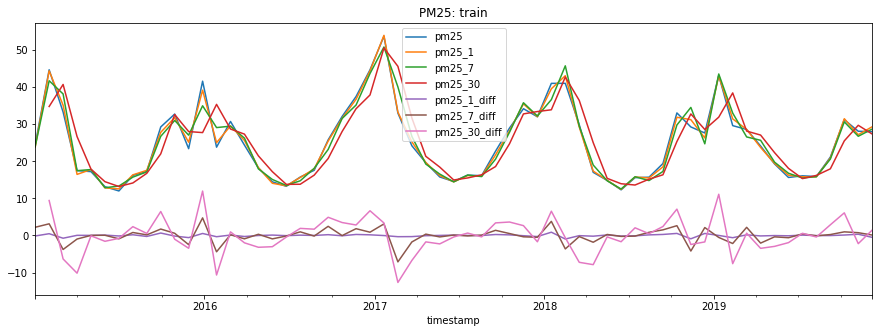

In [0]:
train[['pm25','pm25_1','pm25_7','pm25_30','pm25_1_diff','pm25_7_diff','pm25_30_diff']].resample('30d').mean().plot(title='PM25: train', figsize=(15, 5));

### teraz uzupełniamy test o dodatkowe kolumny związane z odniesieniem do trendu, bazujemy na danych z train

In [0]:
test['pm25_7'] = 0
test['pm25_30'] = 0
test['pm25_7_diff'] = 0
test['pm25_30_diff'] = 0

In [0]:
def ComputeTrendsForTest():
  start_time = time.time()
  with tqdm(total=test.shape[0]) as pbar:
    for index, row in test.iterrows():
        timestamp = row['timestamp']
        df = train[(train.timestamp==(timestamp + pd.DateOffset(hours=-24)))]['pm25_7']
        test.loc[index,'pm25_7'] = np.mean(df)
        df = train[(train.timestamp==(timestamp + pd.DateOffset(hours=-24)))]['pm25_30']
        test.loc[index,'pm25_30'] = np.mean(df)
        df = train[(train.timestamp==(timestamp + pd.DateOffset(hours=-24)))]['pm25_7_diff']
        test.loc[index,'pm25_7_diff'] = np.mean(df)
        df = train[(train.timestamp==(timestamp + pd.DateOffset(hours=-24)))]['pm25_30_diff']
        test.loc[index,'pm25_30_diff'] = np.mean(df)
        pbar.update(1)    
  end_time = time.time()
  print("Elapsed time was %g seconds" % (end_time - start_time))   

In [0]:
ComputeTrendsForTest()

In [0]:
test['pm25_7_diff'] = test['pm25_last_day_mean']-test['pm25_7']
test['pm25_30_diff'] = test['pm25_last_day_mean']-test['pm25_30']

## przygotowujemy funkcję do predykcji na test, próby zdecydowanie pokazały, że godzinowy lag ma bardzo duży wpływ na wyniki predykcji (co najmniej 50%-60%), więc zależy nam na nim. Po pierwsze predykcja odbywać się będzie "przerwa po przerwie" a w dalszej kolejności wiersz po wierszu, jako lag w kolejnej predykcji (poza pierwszym wierszem "przerwy") brana będzie predykcja poprzedniego wiersza

In [0]:
from tqdm import tqdm
import datetime
import time
def ComputeTest(df):
  y_pred = []
  start_time = time.time()
  with tqdm(total=df.shape[0]) as pbar:
    # data obojętne jaka, byleby była przed całym zbiorem
    last_timestamp = datetime.datetime(2014, 1, 1, 0)     
    last_pred = 0
    for index, row in df.iterrows():
        if (index == (last_timestamp + pd.DateOffset(hours=1))):
            # bierzemy poprzednią predykcję i robimy nową
            # tutaj ustawienie pm25_lag
            df.loc[index,'pm25_log_lag'] = last_pred
            last_pred = model.predict(df[df.index==index][feats2].values)
            y_pred = np.append(y_pred,last_pred)
            last_timestamp = index
        else:    
            # bierzemy predykcję z train ale ona już powinna być w test i więc po prostu robimy nową
            last_pred = model.predict(df[df.index==index][feats2].values)
            y_pred = np.append(y_pred,last_pred)
            last_timestamp = index
        pbar.update(1)    
  end_time = time.time()
  print("Elapsed time was %g seconds" % (end_time - start_time))
  return y_pred

## tak ostatecznie wygląda nasz zbiór cech

In [0]:
feats=[ 
       'temperature_last_years_mean',
       'temperature_last_3days_mean', 
       'temperature_last_2days_mean', 
       'temperature_last_day_mean', 
       'cloudCover_last_years_mean', 
       'cloudCover_last_day_mean', 
       'humidity_last_years_mean',
       'humidity_last_day_mean',
       'visibility_last_years_mean',
       'visibility_last_day_mean', 
       'windGust_last_years_mean', 
       'windGust_last_day_mean',
       'windSpeed_last_years_mean',
       'windSpeed_last_day_mean',
       'icon_cat_last_years_mean', 
       'icon_cat_last_day_mean',
       'pressure_last_years_mean', 
       'dewPoint_last_years_mean', 
       'apparentTemperature_last_years_mean', 
       'pressure_last_day_mean', 
       'dewPoint_last_day_mean', 
       'apparentTemperature_last_day_mean', 
        'windBearing_last_years_mean',
        'ozone_cat_last_years_mean',
        'uvIndex_last_years_mean',
        'precipAccumulation_last_years_mean',
        'precipIntensity_last_years_mean',
        'precipProbability_last_years_mean',
        'windBearing_last_day_mean',
        'ozone_cat_last_day_mean',
        'uvIndex_last_day_mean',
        'precipAccumulation_last_day_mean',
        'precipIntensity_last_day_mean',
        'precipProbability_last_day_mean',
       'pm25_log_last_year_mean', 
       'pm25_log_last_years_mean',
       'pm25_log_last_years_min',
       'pm25_log_last_years_max',
       'pm25_log_last_year_weekday_mean',
       'pm25_log_last_years_weekday_mean',
       'pm25_log_last_years_weekday_min',
       'pm25_log_last_years_weekday_max',
       'pm25_log_last_3days_mean',
       'pm25_log_last_3days_min',
       'pm25_log_last_3days_max',
       'pm25_log_last_2days_mean',
       'pm25_log_last_2days_min',
       'pm25_log_last_2days_max',
       'pm25_log_last_day_mean',
       'pm25_log_lag',
        'pm25_7_diff',
        'pm25_30_diff'
       ]

## przygotowanie zbioru treningowego

In [0]:
X_train = train[feats].values
y_train = train['pm25_log'].values

## Walidacja

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
import scikitplot as skplt

### prosta walidacja oparta na jednorazowym podziale zbioru train-test oraz walidacji na foldach (można posprawdzać na XGB, CatBoost oraz LGBM)

In [0]:
xtrain, xtest, ytrain, ytest=train_test_split(X_train, y_train, test_size=0.1)

In [0]:
xgbr = xgb.XGBRegressor(n_estimators=10, random_state=0, max_depth=5, learning_rate=0.6, n_jobs=4, seed=0, objective='reg:squarederror')

In [0]:
xgbr.fit(xtrain,ytrain)

In [0]:
ypred = xgbr.predict(xtest)
mse = mean_squared_error(np.exp(ytest),np.exp(ypred))
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

In [0]:
scores = cross_val_score(xgbr, X_train, y_train, cv=5)
print("Mean cross-validation score: %.4f" % scores.mean())

In [0]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.4f" % kf_cv_scores.mean())

### krzywa walidacji (oglądamy sobie r2) dla XGBoost, CatBoost i LGBM

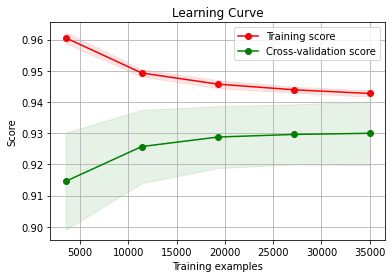

In [0]:
m = xgb.XGBRegressor(n_estimators=10, random_state=0, max_depth=5, learning_rate=0.6, n_jobs=4, seed=0, objective='reg:squarederror')
skplt.estimators.plot_learning_curve(m, X_train, y_train, cv=10, random_state=0, shuffle=True, scoring='r2' );

In [0]:
m = ctb.CatBoostRegressor(n_estimators=300, depth=5, random_state=0, verbose=False, learning_rate=0.6)
m.fit(X_train,y_train)
skplt.estimators.plot_learning_curve(m, X_train, y_train, cv=10, random_state=0, shuffle=True, scoring='r2' );

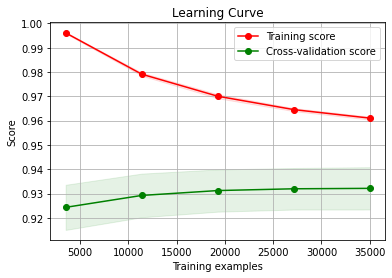

In [0]:
m = lgb.LGBMRegressor(n_estimators=300, depth=4, random_state=0, learning_rate=0.1)
m.fit(X_train,y_train)
skplt.estimators.plot_learning_curve(m, X_train, y_train, cv=10, random_state=0, shuffle=True, scoring='r2' );

## Predykcja (niestety brakło czasu na jakąś automatykę w ramach optymalizacji i więcej eksperymentów, więc nie ma tego kodu, dobór odbywał się na podstawie eksperymentów ręcznych i rozumowania "na oko")

In [0]:
model = lgb.LGBMRegressor(n_estimators=300, depth=4, random_state=0, learning_rate=0.1)
model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              depth=4, importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
%time model.fit(X_train, y_train)

In [0]:
y_pred = ComputeTest(test)
y_pred

In [0]:
test['pm25'] = np.exp(y_pred)

In [0]:
test[ ['id', 'pm25'] ].to_csv('model_xg.csv', index=False)